In [1]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

torch.cuda.set_device(1)

In [2]:
PATH = Path('.')
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

In [3]:
import unicodedata
import pandas as pd
import re
import spacy
import json

In [4]:
def normalize_title(title):
    s = re.sub(r'[^a-zA-Z0-9ñç% ]', ' ', unicodedata.normalize('NFKD', title.lower()).encode('ascii', 'ignore').decode("utf-8"))
#    s = re.sub(r'[\d]+', "1", s)
    s = re.sub(r's |s$', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = re.sub(r'(1 )+', '1 ', s)
    return re.sub(r'o |o$', 'a ', s).strip()

In [5]:
with open("main_categories.json", "r") as f:
    cats = json.load(f)

In [13]:
df = pd.read_csv(PATH / 'train.csv')
df = df[df.language == 'portuguese']
#df.category = df.category.map(cats)
df.title = df.title.apply(normalize_title)
df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

In [12]:
df.head()

,title,label_quality,language,category
2,maquina de lavar electrolux 12 kila,unreliable,portuguese,NaN
3,par disca de freia diant vent gol 8v 08 fremax...,unreliable,portuguese,NaN
5,4 microaspersor irrigacaa ultra 7 20 metra,unreliable,portuguese,NaN
6,raquete clash 100 tour nova,unreliable,portuguese,NaN
7,kit tripe para celular ou camera fotog 1 20m b...,unreliable,portuguese,NaN


In [15]:
df.category = df.category.map(cats)

In [16]:
train, valid = train_test_split(df, test_size=0.1, stratify=df.category, random_state = 42)

In [20]:
processor = SPProcessor('pt', max_vocab_sz=15000, tmp_dir='lm_por_v4')

data_lm = ItemLists('', TextList.from_df(train, cols=['title'], processor=processor),
                        TextList.from_df(valid, cols=['title'], processor=processor))
data_lm = data_lm.label_for_lm()
data_lm = data_lm.databunch(bs=300, num_workers=1)   

In [21]:
data_lm.save('data_lm_v4_por_export.pkl')

In [50]:
data_lm = load_data('', 'data_lm_v4_por_export.pkl', bs=300)

In [21]:
len(data_lm.vocab.itos),len(data_lm.train_ds), len(data_lm.vocab.stoi)

(15000, 8999987, 15000)

In [22]:
data_lm.show_batch(rows=10)

idx,text
0,▁setor ▁hidraulica ▁ford ▁focu ▁2 ▁0 ▁2006 ▁xxbos ▁tupia ▁coluna ▁laminadora ▁p ▁fresa ▁6 ▁8 mm ▁1250 w ▁mdf ▁a cm ▁sh ▁220 v ▁xxbos ▁touca ▁porca ▁com ▁cachecol ▁e ▁luva ▁xxbos ▁capa ▁de ▁cilindra ▁tecida ▁painel ▁de ▁festa ▁sereia ▁3 ▁peca ▁xxbos ▁piva ▁inferior ▁direita ▁da ▁bandeja ▁hyundai ▁hb 20 ▁sedan ▁xxbos ▁mangueira ▁radiador ▁siena ▁2000 ▁2003 ▁4 210 ▁86 72 ▁xxbos ▁galoneira ▁semi ▁industrial ▁xxbos ▁ v au
1,▁3 ▁500 g ▁xxbos ▁levanta dor ▁roda ▁reserva ▁da ▁blazer ▁pc ▁original ▁gm ▁93 258 900 ▁xxbos ▁ dra per ▁kit ▁chave ▁catraca ▁12 ▁peca ▁metrica ▁xxbos ▁impressora ▁termica ▁de ▁bolsa ▁da tec ▁80 mm ▁bluetooth ▁xxbos ▁resistencia ▁da ▁caixa ▁da ▁ar ▁discovery ▁2 ▁03 ▁t ▁300 3 ▁b ▁xxbos ▁nea ▁advance ▁400 g ▁kit ▁57 ▁lata ▁xxbos ▁atacada ▁de ▁gravata ▁menor ▁preca ▁40 ▁peca ▁xxbos ▁automacaa ▁residencial ▁portaa ▁e
2,▁marca ▁ v ini ▁xxbos ▁teni ▁m usa ▁fivela ▁soul ier ▁xxbos ▁a ▁cu ▁xxbos ▁bolsa ▁trilha ▁e ▁ruma ▁rapala ▁vd ▁black ▁50 x 26 x 30 ▁xxbos ▁hvr ▁dvr ▁stand ▁alone ▁8 ▁canai ▁an ka ▁multi ▁hd ▁acessa ▁p 2 p ▁cloud ▁xxbos ▁10 ▁disca ▁serra ▁madeira ▁110 mm ▁40 t ▁para ▁makita ▁serra ▁marmore ▁xxbos ▁carrinha ▁de ▁controle ▁remota ▁x q ▁mustang ▁bos ▁1 ▁10 ▁multikid ▁xxbos ▁ova
3,▁com ▁roda ▁macica ▁s 01 m ▁xxbos ▁fritadeira ▁eletrica ▁profissional ▁4 ▁5 l ▁1 ▁cuba ▁220 v ▁xxbos ▁vela ▁biz ▁100 ▁viraga ▁250 ▁original ▁xxbos ▁pimenta ▁em ▁pa ▁bom ▁sabor ▁caixa ▁com ▁1000 ▁unidade ▁de ▁0 ▁5 g ▁cada ▁xxbos ▁protese ▁peniana ▁com ▁escrota ▁medida ▁12 ▁8 x 3 ▁2 cm ▁xxbos ▁35 ▁giz e ▁massinha ▁lapi ▁core ▁100 ▁cortadore ▁xxbos ▁teclada ▁compativel ▁hp ▁ultrabook ▁sg 57 900 ▁40 a
4,▁xxbos ▁vinil ▁adesiva ▁para ▁banheira ▁cozinha ▁ambiente ▁33 ▁6 ▁metra ▁xxbos ▁linha ▁la ▁mai ▁bebe ▁circula ▁100 g ▁kit ▁10 ▁novela ▁xxbos ▁ponteira ▁esquerda ▁mb ▁axor ▁25 44 ▁usada ▁recondicionada ▁xxbos ▁35 ▁pochete ▁cartucheira ▁de ▁perna ▁motoboy ▁camping ▁pe sc ▁xxbos ▁barraca ▁patrulha ▁canina ▁16 27 ▁multibrink ▁xxbos ▁capacitor ▁25 uf ▁440 vac ▁kit ▁5 ▁unidade ▁xxbos ▁lixadeira ▁esmerilhadeira ▁politriz ▁180 mm ▁1400 w ▁sh 60 302 ▁xxbos ▁bomba ▁de
5,▁17 t ▁mu gen ▁mtx 4 ▁fab model isma ▁xxbos ▁relogia ▁de ▁pulsa ▁feminina ▁gravador ▁profissional ▁voz ▁a ▁be 6 ▁xxbos ▁motor ▁vidra ▁eletrica ▁diant ▁tra ▁direita ▁hyundai ▁i 30 ▁2010 ▁xxbos ▁mesa ▁digitalizadora ▁wacom ▁intua ▁pra ▁p th 660 ▁xxbos ▁kit ▁3 ▁escova ▁magica ▁alisadora ▁bivolt ▁queima ▁de ▁estoque ▁xxbos ▁parafusa ▁prisioneira ▁base ▁rack ▁jeep ▁compas ▁07 ▁ 065 116 72 aa ▁xxbos ▁jaguar ▁scx ▁rarissima ▁xxbos ▁joga ▁capa
6,line ▁ch ▁6 ▁tomada ▁bivolt ▁xxbos ▁coleira ▁antipulga ▁ser esta ▁p ▁cae ▁ate ▁8 ▁kg ▁3 ▁unidade ▁bayer ▁xxbos ▁bateria ▁para ▁notebook ▁dell ▁pn ▁9 t cx n ▁6 ▁celula ▁marca ▁bringit ▁xxbos ▁kit ▁bolsa ▁maternidade ▁rosa ▁ou ▁azul ▁com ▁mochila ▁xxbos ▁eixa ▁comanda ▁valvula ▁punta ▁sporting ▁dualogic ▁1 ▁8 ▁etorq ▁2012 ▁xxbos ▁ap oque l ▁5 ▁4 mg ▁comba ▁com ▁2 ▁caixa ▁40 ▁comp ▁ v ▁jan ▁20 21
7,▁portugue ▁xxbos ▁pedra ▁de ▁sal ▁rosa ▁da ▁himalaia ▁5 cm ▁original ▁7 kg ▁xxbos ▁kit ▁2 ▁desempenadeira ▁grande ▁e ▁media ▁massa ▁corrida ▁gessa ▁xxbos ▁saida ▁de ▁praia ▁infantil ▁unicornia ▁boa ▁qualidade ▁xxbos ▁frasqueira ▁maleta ▁de ▁maa ▁maquiagem ▁acessoria ▁oncinha ▁xxbos ▁adesiva ▁skin ▁notebook ▁rei ▁ar th ur ▁04 ▁xxbos ▁anti ▁estatica ▁cabela ▁escova ▁oval ▁massage ▁pente ▁paddle ▁cabe ▁xxbos ▁vinha ▁tinta ▁seca ▁tradicional ▁bag ▁in ▁box ▁3 l ▁j ota
8,▁xxbos ▁kit ▁1 car rega dor ▁para ▁pilha ▁flex ▁4 ▁pilha ▁rec ▁tip oa aa ▁1100 ▁xxbos ▁hd ▁500 gb ▁para ▁notebook ▁toshiba ▁a 205 ▁s 680 8 ▁hd 1 nc ▁xxbos ▁rola ▁microfibra ▁23 cm ▁ 327 ▁19 ▁atla ▁2 ▁un ▁xxbos ▁maquina ▁brilha nce ▁da ▁singer ▁xxbos ▁refil ador ▁fita ▁de ▁borda ▁manual ▁marca ▁ind f ema ▁melhor ▁marca ▁xxbos ▁cozinha ▁ka li ▁nicioli ▁100% ▁mdf ▁em ▁ate
9,▁football ▁24 x 16 cm ▁na ▁cartela ▁xxbos ▁grelha ▁argentina ▁55 ▁x ▁50 ▁cm ▁xxbos ▁playstation ▁vita ▁slim ▁modela ▁wi ▁fi ▁aqua ▁blue ▁xxbos ▁bola ▁de ▁teni ▁comba ▁4 ▁tuba ▁lacrada ▁xxbos ▁carrinha ▁ford ▁f 100 ▁

In [22]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [23]:
perplexity = Perplexity()
learn = language_model_learner(data_lm, AWD_LSTM, config=config, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy, perplexity])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


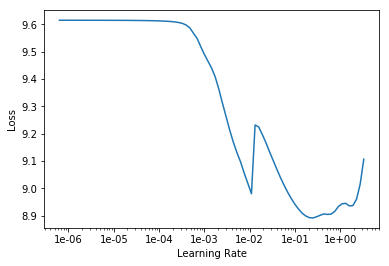

In [25]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr = 3e-3
lr *= learn.data.batch_size/48

In [25]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), wd = 0.01, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy', name='best_lm_por_v4')])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.618226,4.441617,0.270992,84.911972,49:36
1,4.635575,4.425047,0.269692,83.516922,50:17
2,4.583290,4.355723,0.276882,77.923096,50:21
3,4.465241,4.253378,0.286662,70.342690,50:21
4,4.368321,4.162195,0.296776,64.212387,50:16
5,4.278522,4.065230,0.306797,58.278278,49:46
6,4.177175,3.968241,0.317340,52.891312,49:42
7,4.089588,3.879733,0.327629,48.411232,50:17
8,4.018136,3.823207,0.334488,45.750648,50:19
9,3.994652,3.809402,0.336307,45.123425,49:48


Better model found at epoch 0 with accuracy value: 0.27099207043647766.
Better model found at epoch 2 with accuracy value: 0.27688243985176086.
Better model found at epoch 3 with accuracy value: 0.286661833524704.
Better model found at epoch 4 with accuracy value: 0.29677632451057434.
Better model found at epoch 5 with accuracy value: 0.3067971169948578.
Better model found at epoch 6 with accuracy value: 0.317339688539505.
Better model found at epoch 7 with accuracy value: 0.32762885093688965.
Better model found at epoch 8 with accuracy value: 0.3344882130622864.
Better model found at epoch 9 with accuracy value: 0.3363065719604492.


In [26]:
learn.data.vocab.save(('models/v4_vocab_por' + '.pkl'))

In [27]:
learn.save_encoder('best_lm_por_v4_encoder')

In [11]:
learn.predict('celular moto g', 10, temperature=0.75)

'celular moto g 4 ▁plu ▁branca ▁tela ▁5 ▁5 ▁android ▁6 ▁0 ▁xxbos'

In [28]:
del learn
torch.cuda.empty_cache()

In [29]:
df.category = df.category.map(cats)

In [30]:
df.head()

,title,label_quality,language,category
2,maquina de lavar electrolux 12 kila,unreliable,portuguese,NaN
3,par disca de freia diant vent gol 8v 08 fremax...,unreliable,portuguese,NaN
5,4 microaspersor irrigacaa ultra 7 20 metra,unreliable,portuguese,NaN
6,raquete clash 100 tour nova,unreliable,portuguese,NaN
7,kit tripe para celular ou camera fotog 1 20m b...,unreliable,portuguese,NaN


In [10]:
vocab = Vocab.load('models/v4_vocab_por' + '.pkl')

In [11]:
train, valid = train_test_split(df, test_size=0.1, stratify=df.category, random_state = 42)

In [31]:
data_class = ItemLists('', TextList.from_df(train, vocab=data_lm.vocab, cols=['title'], processor=SPProcessor.load('',tmp_dir='lm_por_v4')),
                        TextList.from_df(valid, vocab=data_lm.vocab, cols=['title'], processor=SPProcessor.load('',tmp_dir='lm_por_v4')))
data_class = data_class.label_from_df(cols=['category'])
data_class = data_class.databunch(bs=800, num_workers=1)   

In [32]:
data_class.save('data_class_v4_por_export.pkl')

In [5]:
data_class = load_data('', 'data_class_v4_por_export.pkl', bs=500, num_workers=1)

In [33]:
data_class.show_batch(rows=10)

text,target
▁xxbos ▁re m ot ▁5 605 ▁akb 749 556 06 ▁a sn w 092 hd w 0 ▁u sn q 092 w sg 3 ▁a sn q 122 b ▁a sn q 24 2 c ▁a sn w 092 b ▁a sn w 122 b ▁a sn q 092 b 4 a 0 ▁a sn q 092 w sa 0 ▁a sn q 122 b 4 a 0,Eletrodomesticos
▁xxbos ▁fonte ▁carregador ▁original ▁sony ▁ac ▁l 200 ▁dcr hc 94 ▁dcr ▁hc 94 e ▁dcr hc 94 e ▁dcr ▁hc 96 ▁dcr hc 96 ▁dcr ▁hc 96 e ▁dcr hc 96 e ▁dcr ▁ip 1,Cameras e Acessorios
▁xxbos ▁4 e 959 708 6 b fd ab 020 2 f 59 299 c 10 b 2 b 0 d 91 ea 02 af 856 055 e 50 97 321 dc 4 e 95,Eletrodomesticos
▁xxbos ▁16 gb ▁2 x ▁8 gb ▁2 r x 4 ▁pc 3 l ▁10 600 r ▁x 3 650 ▁x 350 ▁r 410 ▁r 610 ▁60 531 3 ▁ 071,Informatica
▁xxbos ▁capa ▁case ▁west ▁canon ▁t 4 ▁t 5 ▁t 3 i ▁t 4 i ▁t 5 i ▁t 6 i ▁dslr ▁t 6 ▁5 d ▁6 d ▁7 d,Cameras e Acessorios
▁xxbos ▁02 ▁cilindra ▁02 ▁cartucha ▁toner ▁compativel ▁para ▁usa ▁em ▁brother ▁dcp ▁8 085 ▁dcp ▁80 80 ▁tn ▁650 ▁dr ▁620 ▁mfc ▁8 890 ▁80 70 ▁mfc ▁8 480,Informatica
▁xxbos ▁tela ▁10 ▁1 ▁led ▁m 101 n wt 2 ▁b 101 a w 03 ▁hs d 101 pf w 2 ▁lp 101 w sa ▁n 101 l 6,Informatica
▁xxbos ▁bateria ▁p ▁hp ▁h st nn ▁yb 4 d ▁h st nn ▁db 4 d ▁vk 04 ▁6 948 64 ▁ 851 ▁h 4 q 45 aa,Informatica
▁xxbos ▁sensor ▁fase ▁da ▁comanda ▁kia ▁cerata ▁1 ▁6 ▁16 v ▁a ▁partir ▁ana ▁2010 ▁marca ▁auto tra x ▁similar ▁aa ▁codiga ▁39 350 2 b 030,Acessorios para Veiculos
▁xxbos ▁ci ▁q 046 5 r ▁f sq 046 5 r ▁dm 046 5 r ▁fs d m 046 5 r ▁dm 046 5 ▁q 046 5,"Eletronicos, Audio e Video"


In [6]:
num_trn = len(data_class.train_ds.x)
num_val = len(data_class.valid_ds.x)
num_trn, num_val, num_trn+num_val

(8999986, 999999, 9999985)

In [7]:
trn_LabelCounts = np.unique(data_class.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_class.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([1739553,  251662,  225314,  164995,   49551,  182072,  192908,  428325,  275843,  350470,  163964,   12946,
        1456926,  175532,  320116,  398103,  626521,  611532,  102969,   52121,  466488,   11550,  278432,   83590,
          30826,  163668,   18050,  165959]),
 array([193284,  27962,  25035,  18333,   5506,  20230,  21434,  47592,  30649,  38941,  18218,   1438, 161881,  19504,
         35568,  44234,  69614,  67948,  11441,   5791,  51832,   1283,  30937,   9288,   3425,  18185,   2006,  18440]))

In [8]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8067160326693842,
  0.9720375120583521,
  0.9749650721678901,
  0.9816671937045235,
  0.9944943247689496,
  0.9797697463084942,
  0.9785657444356024,
  0.9524082593017367,
  0.9693507301011357,
  0.9610588283137329,
  0.9817817494382769,
  0.9985615533179718,
  0.8381190815185713,
  0.980496414105533,
  0.9644315002267781,
  0.9557662645253003,
  0.9303864472678068,
  0.9320518943029467,
  0.9885589822028612,
  0.9942087687691958,
  0.948167919372319,
  0.9987166646703672,
  0.9690630629869869,
  0.9907122077745454,
  0.9965748835609299,
  0.9818146383783264,
  0.9979944413246865,
  0.9815600824267949],
 [0.8067158067158067,
  0.972037972037972,
  0.9749649749649749,
  0.9816669816669816,
  0.9944939944939944,
  0.9797699797699798,
  0.9785659785659786,
  0.9524079524079524,
  0.9693509693509693,
  0.961058961058961,
  0.9817819817819817,
  0.9985619985619986,
  0.8381188381188381,
  0.9804959804959805,
  0.9644319644319644,
  0.9557659557659558,
  0.9303859303859304,
  0.932051932

In [9]:
len(trn_weights), len(val_weights)

(28, 28)

In [10]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): 
    y_pred = np.argmax(inp, axis=-1)
    return f1_score(targ, y_pred, average='weighted',  labels=np.unique(y_pred))

class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [11]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [40]:
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load_encoder('best_lm_por_v4_encoder');

In [41]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [42]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 6.31E-02


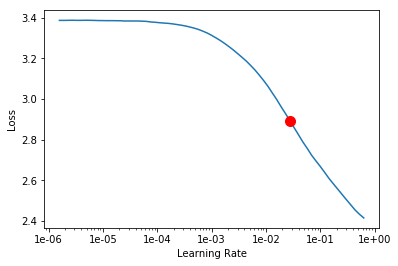

In [43]:
learn_c.lr_find()
learn_c.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [44]:
learn_c.fit_one_cycle(2, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.065009,0.968787,0.900880,21:05
1,1.042167,0.943078,0.907831,20:56


In [45]:
learn_c.show_results(rows=300)

text,target,prediction
▁xxbos ▁controle ▁akb 74 675 304 ▁ts nc 092 t ma 0 ▁a mb fla z ▁ts nc 092 t ma 0 ▁a mb fl sp ▁a sn q 182 c 4 a 0 ▁am bb l sp ▁a sn q 182 cr w 0 ▁am r bl sp ▁a sn q 182 c sa 1 ▁am bb la z,Eletrodomesticos,"Eletronicos, Audio e Video"
▁xxbos ▁remota ▁akb 74 675 304 ▁lm ▁c 182 lt a 0 ▁am bal at ▁lm ▁c 24 2 lt a 0 ▁am bal at ▁ts nh 072 y da 0 ▁am bb l sp ▁ts nh 072 y da 0 ▁sm bb la z ▁ts nh 072 y ma 0 ▁am bb la z,Eletrodomesticos,"Eletronicos, Audio e Video"
▁xxbos ▁teclada ▁acer ▁aspire ▁5 745 p g ▁58 10 ▁58 10 t ▁58 10 t g ▁58 10 tz ▁5 820 ▁5 820 g ▁5 820 t ▁5 820 tz ▁5 820 t g ▁5 820 tz g ▁75 35 ▁75 35 g ▁p k 130 pi 1 a 27,Informatica,Informatica
▁xxbos ▁rede ▁c ▁corda ▁branca ▁1 ▁9 x 1 ▁48 ▁4 ▁8 x 1 ▁42 ▁kit ▁rede ▁1 ▁41 x 1 ▁71 ▁24 x 2 ▁18 ▁1 ▁33 x 1 ▁6 ▁1 ▁38 x 1 ▁44 ▁1 ▁36 x 1 ▁60 ▁1 ▁45 x 5 ▁0,"Casa, Moveis e Decoracao","Casa, Moveis e Decoracao"
▁xxbos ▁par ▁barra ▁led ▁a ▁b ▁42 lb 5500 ▁42 lb 5600 ▁42 lb 5800 ▁42 lb 6200 ▁42 lb 6500 ▁42 lf 58 50 ▁42 lf 6200 ▁42 lf 6400 ▁42 lf 6 450 ▁42 lf 6500 ▁42 l x 330 c,"Eletronicos, Audio e Video","Eletronicos, Audio e Video"
▁xxbos ▁6 b 8 ee e 0 a 60 3 b 8 af 3 a 16 38 d d 0 a 650 7 c fa 8 560 a 50 9 bc 357 fb 2 c 2 16 d 2 a 32 e 28,Eletrodomesticos,"Eletronicos, Audio e Video"
▁xxbos ▁placa ▁de ▁rede ▁servidor ▁lr ▁link ▁10 gb ▁x 8 ▁98 12 af ▁2 sf p ▁dual ▁port ▁sfp ▁b cm 578 10 ▁r 410 ▁r 610 ▁r 710 ▁t 410 ▁t 420 ▁t 430 ▁t 440 ▁t 640 ▁t 340,Informatica,Informatica
▁xxbos ▁re m ot ▁akb 74 675 304 ▁rep oe ▁akb 733 156 06 ▁akb 733 15 607 ▁akb 733 15 608 ▁akb 733 15 609 ▁akb 733 156 11 ▁akb 734 557 11 ▁akb 734 557 12 ▁akb 734 557 15,Eletrodomesticos,"Eletronicos, Audio e Video"
▁xxbos ▁1 b 9 e 21 459 e 2 c 0 d 6 c 6 f 42 905 b 853 aa db d 2 d 087 af 573 c f 050 d 1 e 32 e 0 b 0 dc 82,Eletrodomesticos,"Eletronicos, Audio e Video"
▁xxbos ▁4 a 84 f 66 f 7 f 190 4 a fb 4 c 30 ace e 3 e 688 c 07 f 79 e 5 df 7 990 e 71 cd 147 4 b 8 d 6 b 97,Eletrodomesticos,"Eletronicos, Audio e Video"


In [47]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, 3e-2, wd=0.01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.913038,0.852880,0.931486,21:00
1,0.862263,0.820720,0.940348,21:46


In [48]:
learn_c.save('/data/anime/ml/classifier_por_v4')

In [49]:
lr = 3e-2
wd = 0.01
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.861995,0.822981,0.941195,25:12
1,0.825978,0.791354,0.949409,25:17


In [50]:
learn_c.save('/data/anime/ml/classifier_por_v4_2')

In [13]:
lr = 3e-2
wd = 0.01
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load('/data/anime/ml/classifier_por_v4_2')
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.216092,0.179692,0.951075,48:20
1,0.188706,0.173549,0.952494,47:50


In [14]:
learn_c.save('/data/anime/ml/classifier_por_v4_3')

In [12]:
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load('/data/anime/ml/classifier_por_v4_3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8999986 items)
x: TextList
▁xxbos ▁sapateira ▁de ▁porta ▁em ▁aca ▁para ▁12 ▁pare ▁com ▁gancha ▁sem ▁fura,▁xxbos ▁na ▁poa ▁cacha ▁da ▁sonha ▁salon ▁line ▁500 ml ▁lancamenta,▁xxbos ▁dis ga ea ▁d 2 ▁a ▁bright er ▁dark nes ▁ps 3 ▁midia ▁fisica ▁lacrada,▁xxbos ▁colar ▁gargantilha ▁profissaa ▁ga stro nom ia ▁escrita ▁folheada,▁xxbos ▁celular ▁lg ▁k 9
y: CategoryList
Casa, Moveis e Decoracao,Beleza e Cuidado Pessoal,Games,Joias e Relogios,Celulares e Telefones
Path: .;

Valid: LabelList (999999 items)
x: TextList
▁xxbos ▁bolsa ▁transporte ▁aviaa ▁cia ▁aerea ▁azul ▁cae ▁gata ▁brinde,▁xxbos ▁carta ▁de ▁baralha ▁tiffany ▁na ▁embalagem,▁xxbos ▁citronela ▁olea ▁pura ▁concentrada ▁500 ▁ml ▁2 ▁olea ▁eucalipta ▁ w nf,▁xxbos ▁gabinete ▁madri ▁media ▁branca,▁xxbos ▁airfryer ▁fritadeira ▁eletrica
y: CategoryList
Animais,Brinquedos e Hobbies,Saude,Casa, Moveis e Decoracao,Eletrodomesticos
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEnc

In [13]:
learn_c.export('/data/anime/ml/classifier_por_v4_3_export')